In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from math import radians, sin, cos, asin, sqrt
import re
import requests
import datetime
from statistics import median, quantiles


import geohash2
import pyproj
from pyproj import Proj, transform, CRS
from functools import partial
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
from scipy.spatial import cKDTree
from scipy.stats import poisson

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from ortools.linear_solver import pywraplp


from tqdm import tqdm
from time import sleep

# Data Loading

## Loading the map details for visual outputs

In [2]:
geo_bundesländer = gpd.read_file('./GeoDaten/DE_NUTS5000.gpkg')
geo_würzburg = geo_bundesländer[geo_bundesländer['NUTS_NAME'].str.contains('Würzburg')]
geo_würzburg = geo_würzburg.to_crs('3035')

## Loading the Cluster Dataset and assigning a value of demand to them

In [ ]:
# Anhand der Packungsgrößen berechnet (N1 - N3), aufsummiert auf ein Jahr
# 2022 1.405 Mio. Packungen abgegeben

In [42]:
customers_gdf = gpd.read_file('./WLP/cluster_wuerzburg.gpkg')
customers_gdf['Alter'] = customers_gdf['Alter'].apply(json.loads)

In [43]:
# Assuming 'customers_gdf' is your GeoPandas DataFrame
probabilities = {
    '0-10': 0.01,
    '10-20': 0.02,
    '20-30': 0.03,
    '30-40': 0.04,
    '40-50': 0.07,
    '50-60': 0.09,
    '60-70': 0.1,
    '70-80': 0.15,
    '80+': 0.2
}

def calculate_demand(row):
    total_demand = 0
    for age_group, count in row['Alter'].items():
        lambda_value = count * probabilities[age_group]
        total_demand += poisson.rvs(lambda_value)
    return total_demand * 365

customers_gdf['nachfrage'] = customers_gdf.apply(calculate_demand, axis=1)

In [44]:
# Berechnung des Gesamtbedarfs ohne die Noise-Punkte
total_demand = customers_gdf[customers_gdf['cluster'] != -1]['nachfrage'].sum()

# Summe der Polygone in jedem Cluster (ohne Noise)
bevoelkerung_sum = customers_gdf[customers_gdf['cluster'] != -1].groupby('cluster')['sum_INSGESAMT_0'].sum()

# Wert der Reihe mit den Noise-Punkten
noise_demand = customers_gdf[customers_gdf['cluster'] == -1]['nachfrage'].iloc[0]

# Verteilung des Noise-Bedarfs auf die anderen Cluster anteilig zur Anzahl der Polygone
for cluster in bevoelkerung_sum.index:
    cluster_demand = noise_demand * (bevoelkerung_sum[cluster] / bevoelkerung_sum.sum())
    customers_gdf.loc[customers_gdf['cluster'] == cluster, 'nachfrage'] += np.round(cluster_demand)

# Entfernen der Reihe mit dem 'cluster'-Wert von -1
customers_gdf = customers_gdf[customers_gdf['cluster'] != -1].reset_index(drop=True)

## Detailed Customer Dataset

In [6]:
bevölkerungs_gdf = gpd.read_file('./WLP/pharmacy_assigned_complete.gpkg')
bevölkerungs_gdf['Alter'] = bevölkerungs_gdf['Alter'].apply(json.loads)
bevölkerungs_gdf['Geschlecht'] = bevölkerungs_gdf['Geschlecht'].apply(json.loads)

#Transform the distances in meters to kilometers
bevölkerungs_gdf['distance_pharmacy'] = bevölkerungs_gdf['distance_pharmacy'] / 1000

# Extract and store the dictionary directly in the column
bevölkerungs_gdf['Alter'] = bevölkerungs_gdf['Alter'].apply(lambda x: x[0])

## Pharmacies Dataset

In [7]:
pharmacy_df = pd.read_csv('./OSM_Data/Würzburg-Apotheken.csv')
pharmacy_gdf = gpd.GeoDataFrame(pharmacy_df, geometry=gpd.points_from_xy(pharmacy_df['lon'], pharmacy_df['lat']), crs=CRS("EPSG:4326"))
pharmacy_gdf = pharmacy_gdf.to_crs(bevölkerungs_gdf.crs)

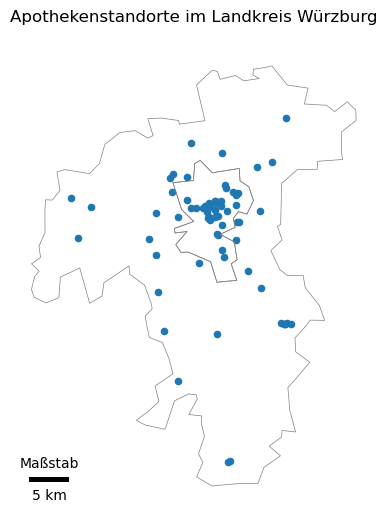

In [8]:
# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_würzburg.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
pharmacy_gdf.plot(ax=ax, markersize=20)

# Titel hinzufügen
plt.title('Apothekenstandorte im Landkreis Würzburg')
plt.axis('off')

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

## 𝑅:  Set of customer regions

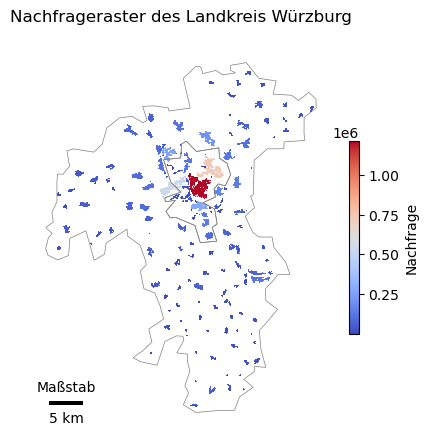

In [9]:
# Create a colormap based on the "nachfrage" column
vmin = customers_gdf['nachfrage'].min()
vmax = customers_gdf['nachfrage'].max()
cmap = 'coolwarm'  

# Plot the raster with boundary
ax = geo_würzburg.boundary.plot(color='gray', linewidth=0.5, figsize = (5,5))

# Plot the customers with custom colormap
customers_gdf.plot(ax=ax, column='nachfrage', cmap=cmap, vmin=vmin, vmax=vmax)

# Add title and labels
plt.axis('off')
plt.title('Nachfrageraster des Landkreis Würzburg')
#plt.xlabel('Breitengradkoordinate im CSR3035 Format')
#plt.ylabel('Längengradkoordinate im CSR3035 Format')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Nachfrage')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.show()

## 𝑊:  Set of warehouses

In [10]:
def geohash_to_csr3035(geohash):
    lat, lon = geohash2.decode(geohash)
    wgs84 = pyproj.Proj(init='epsg:4326')
    csr3035 = pyproj.Proj(init='epsg:3035')
    x_csr3035, y_csr3035 = pyproj.transform(wgs84, csr3035, lon, lat)
    return x_csr3035, y_csr3035


def convert_price_string_to_float(price_string):
  # Remove non-numeric characters
  numeric_part = re.sub(r"[^\d,.]", "", price_string)

  # Replace comma with decimal
  numeric_part = numeric_part.replace(",", ".")

  # Convert to float
  return float(numeric_part)


def extract_largest_float(area_string):
  # Remove non-numeric characters and split the string into parts
  area_parts = re.sub(r"[^\d\-\s]", "", area_string).split()

  # Handle different formats
  if len(area_parts) == 1:  # Single value format (3.000 m²)
    largest_value = float(area_parts[0])

  elif len(area_parts) == 3 and area_parts[1] == '-':  # Range format (5.000 - 15.000 m²)
    largest_value = max(float(area_parts[0]), float(area_parts[2]))

  else:  # Invalid format
    largest_value = None

  return largest_value

def extract_smallest_float(area_string):
  # Remove non-numeric characters and split the string into parts
  area_parts = re.sub(r"[^\d\-\s]", "", area_string).split()

  if len(area_parts) == 1:  # Single value format (3.000 m²)
    smallest_value = float(area_parts[0])

  elif len(area_parts) == 3 and area_parts[1] == '-':  # Range format (5.000 - 15.000 m²)
    smallest_value = min(float(area_parts[0]), float(area_parts[2]))

  else:  # Invalid format
    smallest_value = None

  return smallest_value


In [ ]:
# Read warehouse data from CSV files
warehouse_data_wuerzburg = pd.read_csv('./Immobilien_Data/Wuerzburg.csv')  # Read data from Würzburg CSV
warehouse_data_wuerzburg_kreis = pd.read_csv('./Immobilien_Data/Wuerzburg-Kreis.csv')  # Read data from Würzburg-Kreis CSV

# Combine data from both CSV files
warehouse_data = pd.concat([warehouse_data_wuerzburg, warehouse_data_wuerzburg_kreis], axis=0)  # Concatenate DataFrames

# Extract x and y coordinates from 'geoGrid' column using a function (assumed 'geohash_to_csr3035' is defined elsewhere)
warehouse_data[['x_csr3035', 'y_csr3035']] = warehouse_data['geoGrid'].apply(lambda x: pd.Series(geohash_to_csr3035(x)))

# Create a geometry column using Point objects from x and y coordinates
warehouse_data['geometry'] = warehouse_data.apply(lambda row: Point(row['x_csr3035'], row['y_csr3035']), axis=1)

# Convert the data into a GeoDataFrame with specified geometry column and CRS
warehouses_gdf = gpd.GeoDataFrame(warehouse_data, geometry='geometry', crs='EPSG:3035')

# Reset index to avoid potential issues with duplicate indices
warehouses_gdf = warehouses_gdf.reset_index(drop=True)  # Reset index and optionally drop the old column

# Clean and process 'pricePerSquareMetre' column
warehouses_gdf['pricePerSquareMetre'] = warehouses_gdf[warehouses_gdf['pricePerSquareMetre'].notna()]['pricePerSquareMetre'].apply(convert_price_string_to_float)  # Apply function to non-NaN values to convert price format
warehouses_gdf['pricePerSquareMetre'].fillna(warehouses_gdf['pricePerSquareMetre'].mean(), inplace=True)  # Fill NaN values with the mean
warehouses_gdf['pricePerSquareMetre'] = warehouses_gdf['pricePerSquareMetre'].apply(lambda x: round(x, 2))  # Round price values to 2 decimal places

# Clean and process 'floorSpace' column
warehouses_gdf['floorSpace_big'] = warehouses_gdf['floorSpace'].apply(extract_largest_float)
warehouses_gdf['floorSpace_small'] = warehouses_gdf['floorSpace'].apply(extract_smallest_float)

#Create new column with the corresponding price element
warehouses_gdf['total_price_big'] = warehouses_gdf['floorSpace_big'] * warehouses_gdf['pricePerSquareMetre'] * 12
warehouses_gdf['total_price_small'] = warehouses_gdf['floorSpace_small'] * warehouses_gdf['pricePerSquareMetre'] * 12

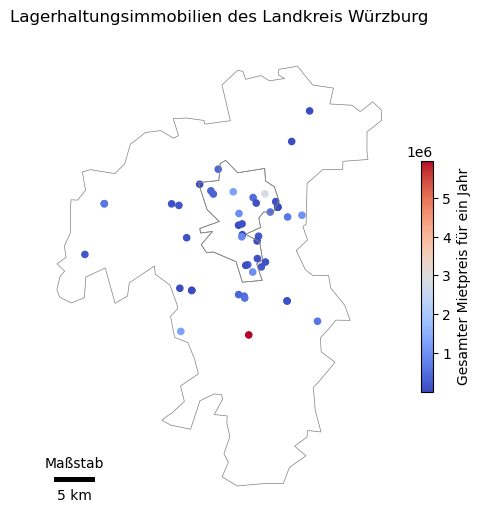

In [12]:
# Create a colormap based on the "total_price" column
vmin = warehouses_gdf['total_price_big'].min()
vmax = warehouses_gdf['total_price_big'].max()
cmap = 'coolwarm'  


# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_würzburg.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf.plot(ax=ax, column='total_price_big', cmap=cmap, markersize=20)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')
plt.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Gesamter Mietpreis für ein Jahr')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

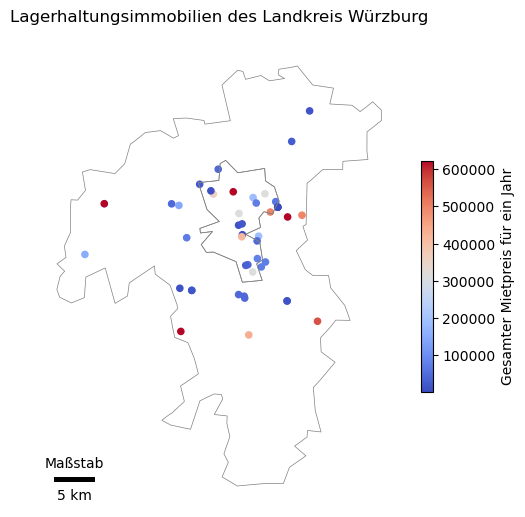

In [13]:
# Create a colormap based on the "total_price" column
vmin = warehouses_gdf['total_price_small'].min()
vmax = warehouses_gdf['total_price_small'].max()
cmap = 'coolwarm'  


# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_würzburg.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf.plot(ax=ax, column='total_price_small', cmap=cmap, markersize=20)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')
plt.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Gesamter Mietpreis für ein Jahr')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

## 𝑆:  Set of links between warehouses and regions

In [14]:
def calculate_travel_costs(warehouses_gdf, customers_gdf):

  # Create an empty list to store the results
  data = []

  # Iterate through each warehouse in the warehouse DataFrame
  for warehouse_index, warehouse in warehouses_gdf.iterrows():
    for customer_index, customer in customers_gdf.iterrows():

      # Calculate the distance between the centroid of the region and the warehouse
      travel_distance = warehouse.geometry.distance(customer.geometry.centroid)/1000
      # Append the calculated values to the list
      data.append({'warehouse_id': warehouse_index, 'region_id': customer_index, 'travel_distance': travel_distance})

  # Create a DataFrame from the collected data
  df = pd.DataFrame(data)
  return df

# Example usage (assuming you have populated your warehouses_gdf and customers_gdf DataFrames)
shifts_df = calculate_travel_costs(warehouses_gdf, customers_gdf)

## Calculating Energy Costs

In [15]:
# Calculate timestamps (current time minus 48 hours and current time)
current_time = datetime.datetime.now()
past_timestamp = (current_time - datetime.timedelta(hours=2190)).timestamp() * 1000
current_timestamp = current_time.timestamp() * 1000

# Construct the API URL with updated timestamps
api_url = f"https://api.awattar.de/v1/marketdata?start={past_timestamp}&end={current_timestamp}"

# Send GET request using the requests library
try:
    response = requests.get(api_url)
    response.raise_for_status()  # Raise an exception for non-2xx status codes
except requests.exceptions.RequestException as error:
    print(f"Error: {error}")

In [16]:
# Load data in json format
data = json.loads(response.content)
# Extract market prices
market_prices = [item["marketprice"] for item in data["data"]]

# Calculate quantiles
q1, q2, q3 = quantiles(market_prices)  # Use quartiles function

# Convert to kWh (if needed)
q1_kwh = q1 / 10
q2_kwh = q2 / 10
q3_kwh = q3 / 10

q2_kwh_eur = q2 / 1000

print(f"Median market price (kWh): {q2_kwh_eur:.5f} Eur/kWh")
print(f"Median market price (kWh): {q2_kwh:.2f} Ct/kWh")
print(f"25th percentile (Q1, kWh): {q1_kwh:.2f} Ct/kWh")
print(f"75th percentile (Q3, kWh): {q3_kwh:.2f} Ct/kWh")

Median market price (kWh): 0.06626 Eur/kWh
Median market price (kWh): 6.63 Ct/kWh
25th percentile (Q1, kWh): 4.95 Ct/kWh
75th percentile (Q3, kWh): 8.08 Ct/kWh


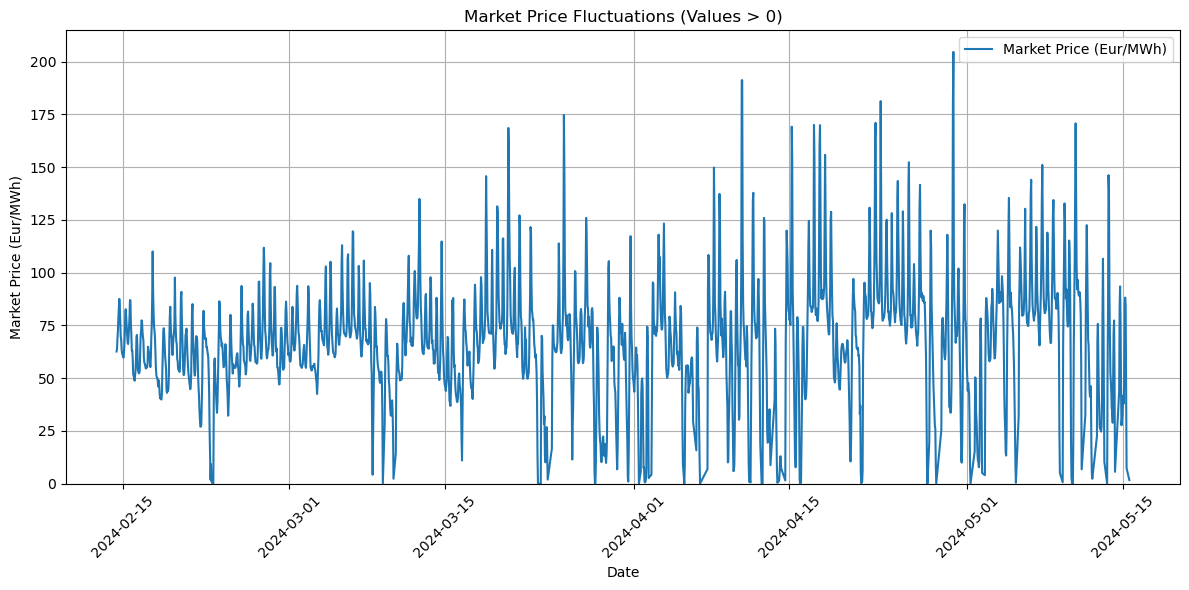

In [17]:
# Convert JSON data to pandas DataFrame
df = pd.DataFrame(data["data"])

# Convert timestamps to datetime format
df["start_timestamp"] = pd.to_datetime(df["start_timestamp"], unit="ms")
df["end_timestamp"] = pd.to_datetime(df["end_timestamp"], unit="ms")

# Filter data for values greater than 0
df_filtered = df[df["marketprice"] > 0]

# Plot market price vs timestamps (using filtered data)
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(df_filtered["start_timestamp"], df_filtered["marketprice"], label="Market Price (Eur/MWh)")

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Market Price (Eur/MWh)")
plt.title("Market Price Fluctuations (Values > 0)")  # Update title

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set y-axis limits to start from 0 (optional)
plt.ylim(bottom=0)  # This ensures the y-axis starts at 0

# Add gridlines
plt.grid(True)

# Show legend
plt.legend()

plt.tight_layout()
plt.show()

# Optimierungsmodel

## Optimierung

In [ ]:
#Capacity
#Time Window
#Resource Constraint

In [18]:
def check_travel_distances(shifts_df, max_flight_distance): 
   # Assuming 'node_a' and 'node_b' are columns containing node IDs, and 'distance' is the distance column
    filtered_data = shifts_df[shifts_df['travel_distance'] < 20]

    # Check if all nodes in set B have connections less than 20
    unique_nodes_b = filtered_data['region_id'].unique()
    all_connected = len(unique_nodes_b) == len(set(shifts_df['region_id']))  # Check if all unique nodes in B are present

    if all_connected:
        return("All nodes in set B have a connection to a node in set A less than 20 units away.")
    else:
        return("Some nodes in set B might not have connections less than 20 units away.")

In [24]:
max_flight_distance = 50 #Kilometer
battery_capacity = 1000 * 3600 #Watt Stunden * 3600 = Joul
Epm =  battery_capacity/(max_flight_distance * 1000)
kWh_km = Epm / 3600000
#cost_per_km = q2_kwh_eur * kWh_km
cost_per_km = 0.05


print(check_travel_distances(shifts_df, max_flight_distance))

shifts_df.set_index(['warehouse_id', 'region_id'], inplace=True)
customers_gdf.set_index(['cluster'], inplace=True)

W = warehouses_gdf.index.values
R = customers_gdf.index.values
S = shifts_df.index.values

M = 1000000

All nodes in set B have a connection to a node in set A less than 20 units away.


In [25]:
def optimize():    
    # Create a solver
    solver = pywraplp.Solver('FacilityLocation', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    # Define decision variables
    x = {}
    for w, r in S:
        x[w,r] = solver.IntVar(0, 1, name=f'x_{w}_{r}')

    y = {}
    for w in W:
        y[w] = solver.IntVar(0, 1, name=f'y_{w}')

    #Objective Function
    objective = solver.Minimize(


    solver.Sum((y[w] * warehouses_gdf.loc[w, 'total_price_small']) for w in W) + 

    # Variable costs for transportation
    2 * cost_per_km * 
    solver.Sum([ 
        s/100 * 
        solver.Sum([
            shifts_df.loc[w,r].travel_distance * x[w,r]
            for w, r in S
        ])
        for s in range(50, 151)
    ])
    )

    # Constraints
    # Regions can only be served by open warehouses
    for w in W:
        for r in R:
            constraint = solver.Constraint(-solver.infinity(), 0)
            constraint.SetCoefficient(x[w,r], 1)
            constraint.SetCoefficient(y[w], -1)

    # Each region has to be served by exactly one warehouse
    for r in R:
        constraint = solver.Constraint(1, 1)
        for w in W:
            constraint.SetCoefficient(x[w,r], 1)


    #The distance from warehouse to customer cant be taller than the maximum flight range of each drone
    for w in W:
        for r in R:
            max_flight_distance >= x[w,r] * shifts_df.loc[w,r].travel_distance 


    # Each warehouse needs a certain amount of space for each customer served
    for w in W:
        customer_demand_sum = solver.Sum(x[w, r] * customers_gdf.loc[r, 'sum_INSGESAMT_0'] for r in R)
        solver.Add(customer_demand_sum * 0.001 <= y[w] * warehouses_gdf.loc[w, 'floorSpace_small'])  # Ensure enough space

    return solver, x, y

In [ ]:
# z = {}
# for w in W:
#   z[w] = solver.IntVar(0, 1, name=f'z_{w}')
 

    # Fixed costs for opening warehouses depending on size
    # solver.Sum((warehouses_gdf.loc[w, 'total_price_big'] * (1 - z[w]) +
    #                     warehouses_gdf.loc[w, 'total_price_small'] * z[w])  for w in W) +


# # Any warehouse size can only be selected if the warehouse is opened
# for w in W:
#   constant = y[w]
#   solver.Add(constant * (z[w] + 0.5) > 0)


# # Each warehouse needs to have a certain amount of space each customer they serve
# for w in W:
#   customer_demand_sum = solver.Sum(x[w, r] * customers_gdf.loc[r, 'sum_INSGESAMT_0'] for r in R)
#   floor_space_requirement = warehouses_gdf.loc[w, 'floorSpace_big']  # Default to large space
#   if z[w] == 1:  # If small space selected
#     floor_space_requirement = warehouses_gdf.loc[w, 'floorSpace_small']
#   solver.Add(customer_demand_sum * 0.0001 <= y[w] * floor_space_requirement)  # Ensure enough space

## Lösungsausgabe

In [26]:
opened_warehouses = []
customers_gdf['assigned_warehouse'] = 0

solver, x, y = optimize()

#Solving the problem
status = solver.Solve()

def print_solution(status, solver, x, y, W, R):

  if status == pywraplp.Solver.OPTIMAL:
    print("Objective value:", solver.Objective().Value())
    print("Opened warehouses:")
    opened_warehouses.clear()  # Clear the list before appending
    for w in W:
      if y[w].solution_value() > 0.5:
        opened_warehouses.append(w)
        print(f"- Warehouse {w}")
        print(f"Floor-Space: {warehouses_gdf.loc[w, 'floorSpace_small']}")
    print("Warehouse assignments:")
    for r in R:
      assigned_warehouse = None
      for w in W:
        if x[w, r].solution_value() > 0.5:
          assigned_warehouse = w
          break
      if assigned_warehouse:
        customers_gdf.loc[r, 'assigned_warehouse'] = assigned_warehouse
        print(f"- Region {r} served by warehouse {assigned_warehouse}")
      else:
        print(f"- Region {r} has no assigned warehouse (might be infeasible)")
  else:
    print("Solver failed to find an optimal solution. Status:", status)


print_solution(status, solver, x, y, W, R)

Objective value: 32913.08200447803
Opened warehouses:
- Warehouse 7
Floor-Space: 15.0
- Warehouse 10
Floor-Space: 250.0
- Warehouse 23
Floor-Space: 28.0
Warehouse assignments:
- Region 0 served by warehouse 7
- Region 1 served by warehouse 7
- Region 2 served by warehouse 7
- Region 3 served by warehouse 23
- Region 4 served by warehouse 23
- Region 5 served by warehouse 7
- Region 6 served by warehouse 7
- Region 7 served by warehouse 7
- Region 8 served by warehouse 7
- Region 9 served by warehouse 7
- Region 10 served by warehouse 7
- Region 11 served by warehouse 7
- Region 12 served by warehouse 7
- Region 13 served by warehouse 23
- Region 14 served by warehouse 7
- Region 15 served by warehouse 7
- Region 16 served by warehouse 7
- Region 17 served by warehouse 7
- Region 18 served by warehouse 7
- Region 19 served by warehouse 7
- Region 20 served by warehouse 7
- Region 21 served by warehouse 7
- Region 22 served by warehouse 7
- Region 23 served by warehouse 7
- Region 24 ser

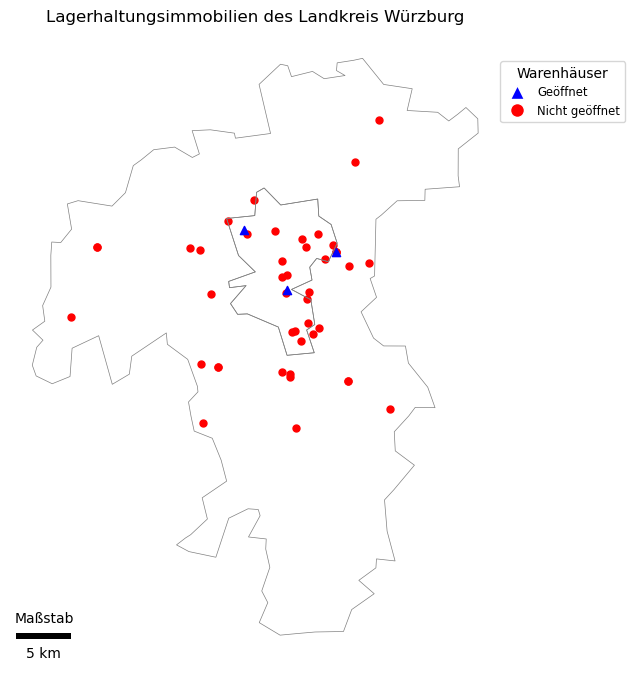

In [27]:
#Rahmen der Grafik definieren
ax = geo_würzburg.boundary.plot(color='gray', linewidth=0.5, figsize = (7,7))

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].plot(ax=ax, color='red', marker='o', markersize=25)
warehouses_gdf.loc[opened_warehouses].plot(ax=ax, color='blue', marker='^', markersize=35)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')

plt.axis('off')

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Add legend
custom_legend = [Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='Geöffnet'),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Nicht geöffnet')]
plt.legend(handles=custom_legend, title='Warenhäuser', bbox_to_anchor=(1,0.95), loc='upper left', borderaxespad=0., fontsize='small', ncol=1)
plt.tight_layout()

# # Index jedes Warehouses anzeigen
# for idx, row in warehouses_gdf.loc[opened_warehouses].iterrows():
#     plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')

# for idx, row in warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].iterrows():
#     plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')

# Zeige den Plot an
plt.show()

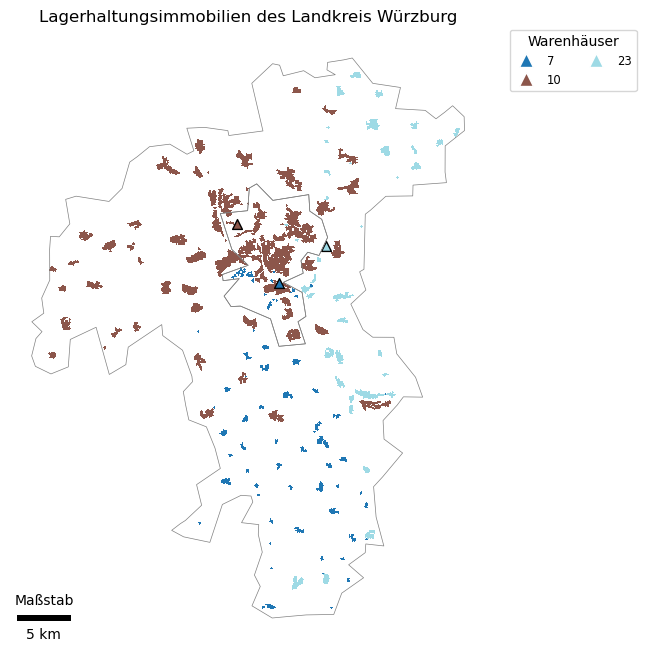

In [28]:
# Create a colormap with a color for each opened warehouse
colors = plt.cm.tab20(np.linspace(0, 1, len(opened_warehouses)))
warehouse_colors = dict(zip(opened_warehouses, colors))

# Create a dictionary to map each warehouse to a color
warehouse_colors = {
    warehouse: color
    for warehouse, color in zip(opened_warehouses, warehouse_colors.values())
}

# Plot the boundaries of the region
ax = geo_würzburg.boundary.plot(color='gray', linewidth=0.5, figsize=(8, 8))


# Plot the customers with the color of their assigned warehouse
for index, row in customers_gdf.iterrows():
    warehouse = row['assigned_warehouse']
    color = warehouse_colors.get(warehouse, 'gray')  # Use gray color if warehouse is not in the dictionary
    customers_gdf.iloc[[index]].plot(ax=ax, color=color, markersize=20)


# Plot the warehouses with their assigned colors
for warehouse, color in warehouse_colors.items():
    warehouses_gdf[warehouses_gdf.index == warehouse].plot(ax=ax, color=color, marker='^', markersize=50, edgecolor='black')


# Turn off axis
plt.axis('off')

# Add title
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')

# Add legend
legend_handles = [Line2D([0], [0], marker='^', color='w', markerfacecolor=color, markersize=10, label=warehouse) for warehouse, color in warehouse_colors.items()]
ax.legend(handles=legend_handles, title='Warenhäuser', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=2)

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Show the plot
plt.show()

## Assigning a warehouse to each building based on the optimal value

In [34]:
# Räumlichen Index für das Cluster-GDF erstellen
cluster_sindex = customers_gdf.sindex

# Funktion, um das zugewiesene Lager für einen Punkt zu finden
def find_assigned_warehouse(point):
    possible_matches_index = list(cluster_sindex.intersection(point.bounds))
    possible_matches = customers_gdf.iloc[possible_matches_index]
    output = possible_matches[possible_matches.geometry.contains(point)]
    if not output.empty:
        return [output.assigned_warehouse.iloc[0]]
    else:
        nearest_polygon_index = cluster_sindex.nearest(point)[0]
        nearest_polygon = customers_gdf.iloc[nearest_polygon_index]
        return [nearest_polygon.assigned_warehouse.iloc[0]]

In [ ]:
# Verfolgen Sie den Fortschritt der apply-Methode
tqdm.pandas()

# Die apply-Methode auf die GeoDataFrame anwenden, um das zugewiesene Lager für jeden Punkt zu finden
warehouses = bevölkerungs_gdf['geometry'].progress_apply(find_assigned_warehouse)

bevölkerungs_gdf['assigned_warehouse'] = 0
bevölkerungs_gdf['distance_warehouse'] = 0

for index, row in tqdm(bevölkerungs_gdf.iterrows(), total=len(bevölkerungs_gdf)):
    bevölkerungs_gdf.loc[index, 'assigned_warehouse'] = warehouses[index][0]
    warehouse_geometry = warehouses_gdf.loc[row['assigned_warehouse']]['geometry']
    population_geometry = row['geometry']
    bevölkerungs_gdf.loc[index, 'distance_warehouse'] = warehouse_geometry.distance(population_geometry) / 1000

## Simulations Loop

In [59]:
# Wahrscheinlichkeitsverteilung
probabilities = {
    '0-10': 0.01,
    '10-20': 0.02,
    '20-30': 0.03,
    '30-40': 0.04,
    '40-50': 0.07,
    '50-60': 0.09,
    '60-70': 0.1,
    '70-80': 0.15,
    '80+': 0.2
}


month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Days in each month (ignoring leap years)

cost_per_km_drone = 0.05
cost_per_km_car = 2

drone_transportation_cost = 0
car_transportation_cost = 0
car_transportation_time = 0
factory_cost = warehouses_gdf.loc[opened_warehouses].total_price_small.sum()


def calculate_demand(row):
    total_demand = 0
    for age_group, count in row['Alter'].items():
        lambda_value = count * probabilities[age_group]
        total_demand += poisson.rvs(lambda_value)
    return total_demand * 365

In [60]:
#Loop der Simulation über ein gesamtes Jahr
for i in range(12):

    print(f'Simulation - Monat: {i + 1}')
    
    tqdm.pandas()
    bevölkerungs_gdf['nachfrage'] = 0
    bevölkerungs_gdf['nachfrage'] = bevölkerungs_gdf.progress_apply(calculate_demand, axis=1)
     

    # Use tqdm to display a progress bar for the loop
    for index, row in tqdm(bevölkerungs_gdf.iterrows(), total=len(bevölkerungs_gdf)):
        nachfrage = row['nachfrage']

        #Kosten des Drohnen Transports
        drone_transportation_cost += cost_per_km_drone * nachfrage * row.distance_warehouse
        
        # Kosten des LKW/PKW Transports
        car_transportation_cost += bevölkerungs_gdf.loc[index].distance_pharmacy * cost_per_km_car * nachfrage
        car_transportation_time += bevölkerungs_gdf.loc[index].time_pharmacy * nachfrage

Simulation - Monat: 1


100%|██████████| 124795/124795 [00:33<00:00, 3770.77it/s]


Simulation - Monat: 2


100%|██████████| 124795/124795 [00:27<00:00, 4590.73it/s]


Simulation - Monat: 3


100%|██████████| 124795/124795 [00:27<00:00, 4562.58it/s]


Simulation - Monat: 4


100%|██████████| 124795/124795 [00:30<00:00, 4108.50it/s]


Simulation - Monat: 5


100%|██████████| 124795/124795 [00:27<00:00, 4549.02it/s]


Simulation - Monat: 6


100%|██████████| 124795/124795 [00:27<00:00, 4546.04it/s]


Simulation - Monat: 7


100%|██████████| 124795/124795 [00:26<00:00, 4667.55it/s]


Simulation - Monat: 8


100%|██████████| 124795/124795 [00:27<00:00, 4527.98it/s]


Simulation - Monat: 9


100%|██████████| 124795/124795 [00:31<00:00, 3930.40it/s]


Simulation - Monat: 10


100%|██████████| 124795/124795 [00:27<00:00, 4531.15it/s]


Simulation - Monat: 11


100%|██████████| 124795/124795 [00:27<00:00, 4586.08it/s]


Simulation - Monat: 12


100%|██████████| 124795/124795 [00:27<00:00, 4523.08it/s]


In [61]:
def print_cost_summary(drone_cost, car_cost, car_time, factory_cost):

  print("-" * 50)
  print("Logistical Cost Summary (per year):")
  print("-" * 50)
  print(f"Drone Transportation Cost: \t€{drone_cost:.2f}")
  print(f"Factory Cost: \t\t\t€{factory_cost:.2f}")
  print("-" * 50)
  print(f"Car/Truck Transportation Cost: \t€{car_cost:.2f}")
  print(f"Car/Truck Transportation Time: \t{car_time/ 60:.2f} hours")
  print("-" * 50)
  print(f"Total Cost Drone: \t\t€{(drone_cost + factory_cost):.2f}")
  print(f"Total Cost Car: \t\t€{(car_cost):.2f}")
  print("-" * 50)

# Call the function after calculating the costs
print_cost_summary(drone_transportation_cost, car_transportation_cost, car_transportation_time, factory_cost)

--------------------------------------------------
Logistical Cost Summary (per year):
--------------------------------------------------
Drone Transportation Cost: 	€35371851.50
Factory Cost: 			€11160.12
--------------------------------------------------
Car/Truck Transportation Cost: 	€1072708186.44
Car/Truck Transportation Time: 	687304477.23 hours
--------------------------------------------------
Total Cost Drone: 		€35383011.62
Total Cost Car: 		€1072708186.44
--------------------------------------------------


# Tests